Loaded boundaries:
Id: [1.694e+08, 2.883e+08] M⁻¹
I0: [1.369e+03, 1.665e+03]


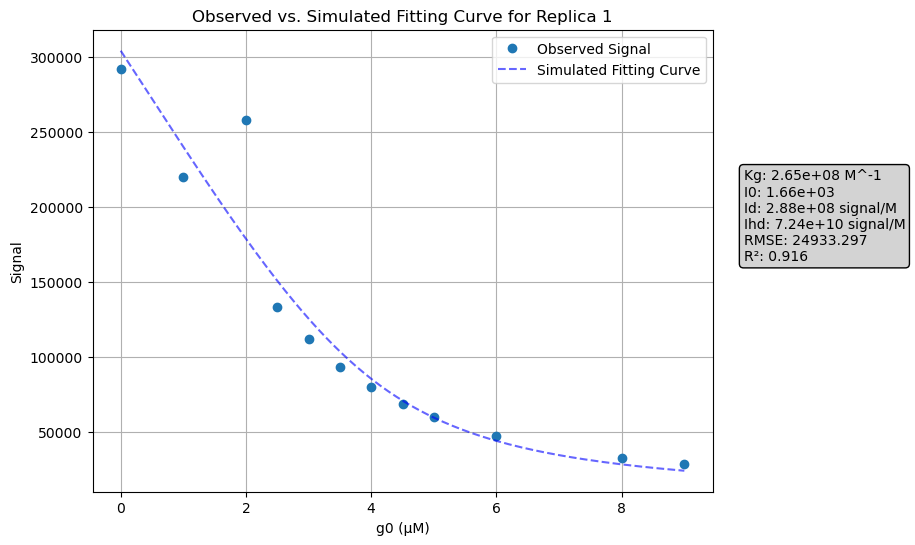

Results for Replica 1 saved to /Users/Frank/Downloads/IDA-fitting/fit_results_replica_1.txt


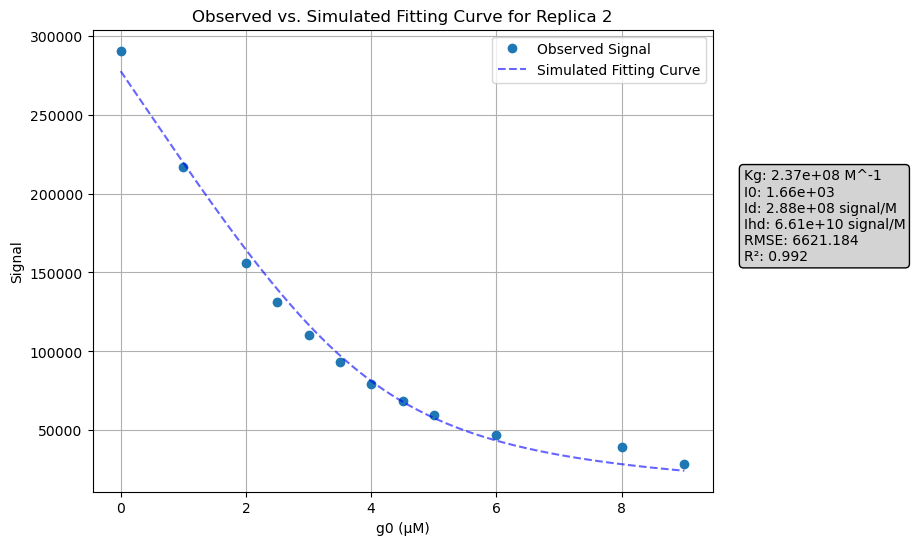

Results for Replica 2 saved to /Users/Frank/Downloads/IDA-fitting/fit_results_replica_2.txt


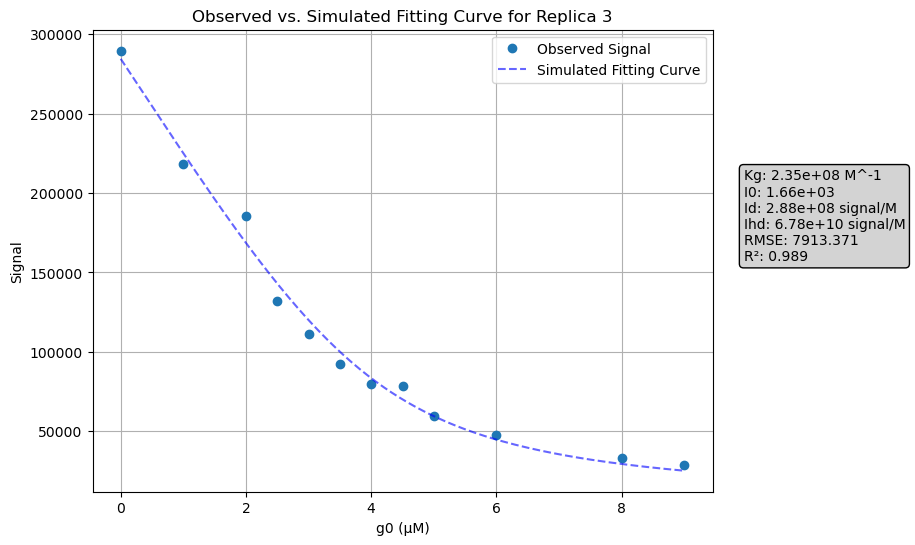

Results for Replica 3 saved to /Users/Frank/Downloads/IDA-fitting/fit_results_replica_3.txt


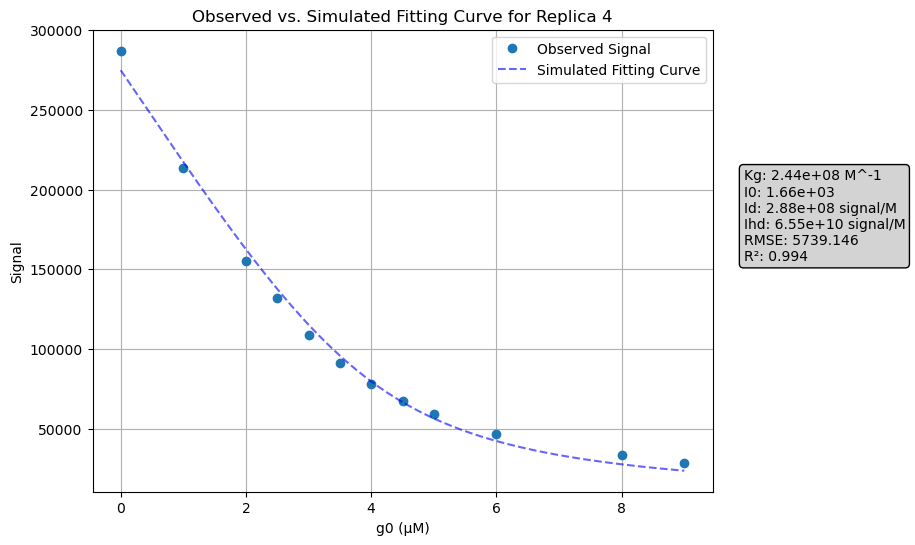

Results for Replica 4 saved to /Users/Frank/Downloads/IDA-fitting/fit_results_replica_4.txt


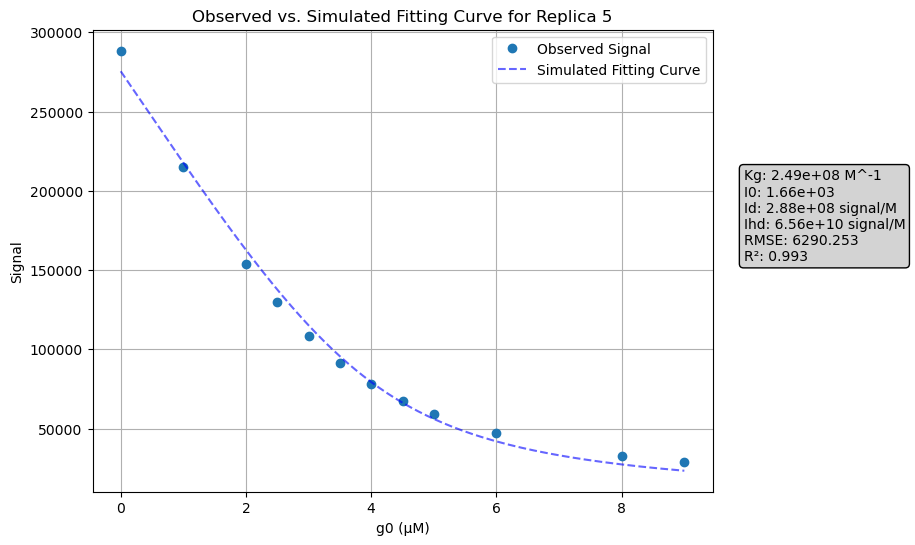

Results for Replica 5 saved to /Users/Frank/Downloads/IDA-fitting/fit_results_replica_5.txt


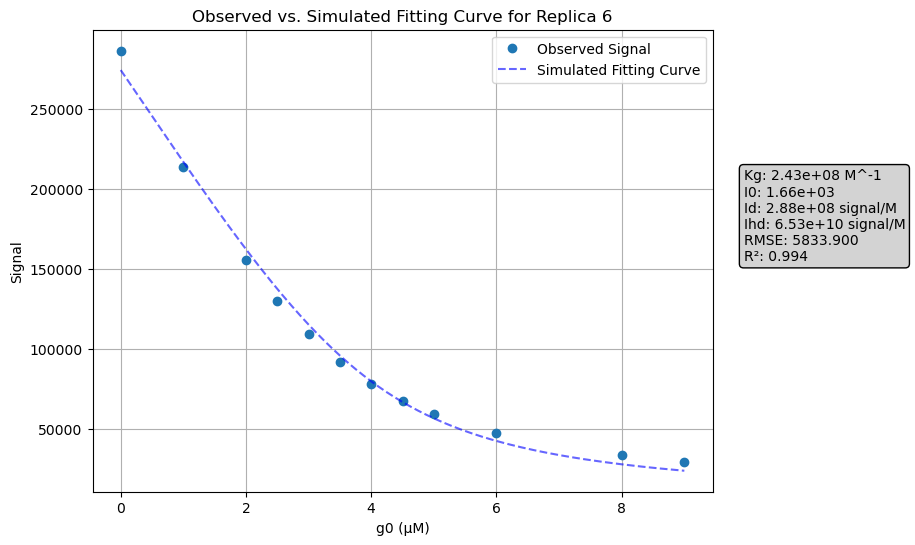

Results for Replica 6 saved to /Users/Frank/Downloads/IDA-fitting/fit_results_replica_6.txt


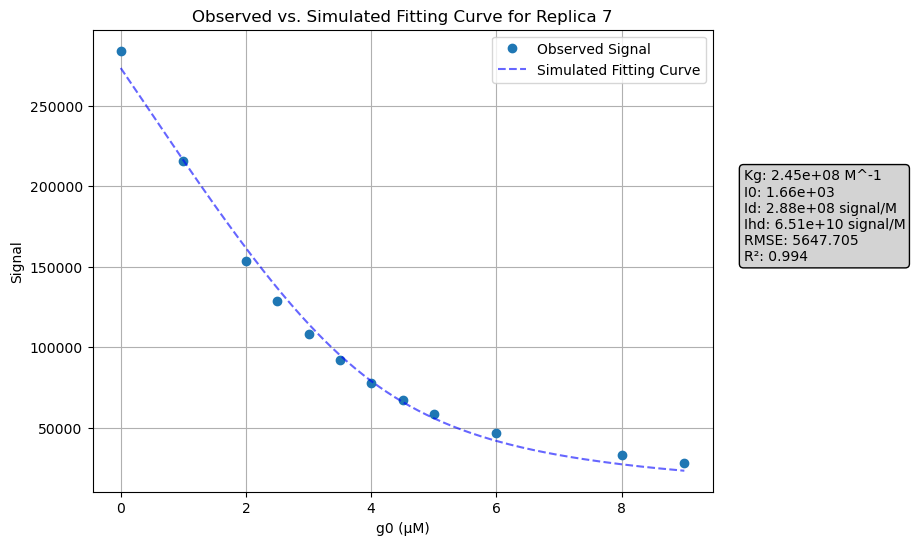

Results for Replica 7 saved to /Users/Frank/Downloads/IDA-fitting/fit_results_replica_7.txt


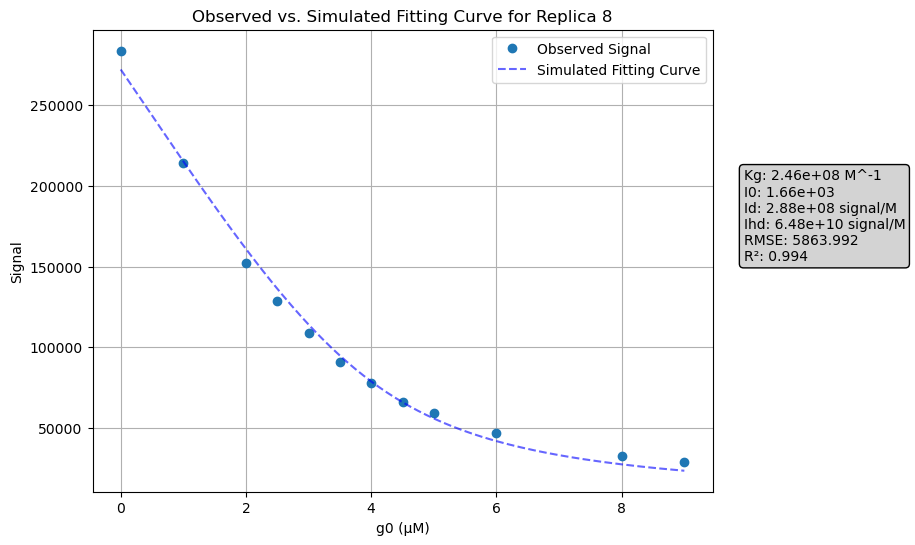

Results for Replica 8 saved to /Users/Frank/Downloads/IDA-fitting/fit_results_replica_8.txt


In [23]:
import numpy as np
from scipy.optimize import brentq, minimize
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from datetime import datetime
import os

# File paths
file_path = '/Users/Frank/Downloads/IDA-fitting/merged_output-IDA.txt'
results_dir = os.path.dirname(file_path)  # Get the directory of the input file
results_file_path = os.path.join(results_dir, 'dye_alone_linear_fit_results.txt')  # Save results in the same directory

# Input constants
Kd_in_M = 1.68e7  # Binding constant for h_d binding in M^-1
h0_in_M = 4.3e-6  # Total initial concentration of host (M)
d0_in_M = 6e-6    # Total initial concentration of dye (M)

#Fitting Thresholds
rmse_threshold_factor = 2  # Factor to multiply the RSME for acceptable fits compared to the best fit.
r2_threshold = 0.9    #R2 value used for filtering acceptable and unacceptable fits.

#################################################################################################################
# Do NOT change code after this line
#################################################################################################################

# Initialize parameter ranges for optimization
I0_range = (0, None)  # Default range for I0 (0, Minimum Signal in the data)
Id_range = (None, None)  # Default range for Id (1e3, 1e18)
Ihd_range = (None, None)  # Default range for Ihd (1e3, 1e18)

# Load bounds from results file if available
if os.path.exists(results_file_path):
    try:
        # Read bounds for Id and I0 from the file
        with open(results_file_path, 'r') as f:
            lines = f.readlines()
        id_prediction_line = next((line for line in lines if 'Id prediction interval' in line), None)
        if id_prediction_line and 'not applicable' not in id_prediction_line:
            Id_lower = float(id_prediction_line.split('[')[-1].split(',')[0].strip())
            Id_upper = float(id_prediction_line.split(',')[-1].split(']')[0].strip())
        else:
            average_Id = float(next(line for line in lines if 'Average Id' in line).split('\t')[-1].strip())
            Id_lower = 0.5 * average_Id
            Id_upper = 2.0 * average_Id
        i0_prediction_line = next((line for line in lines if 'I0 prediction interval' in line), None)
        if i0_prediction_line and 'not applicable' not in i0_prediction_line:
            I0_lower = float(i0_prediction_line.split('[')[-1].split(',')[0].strip())
            I0_upper = float(i0_prediction_line.split(',')[-1].split(']')[0].strip())
        else:
            average_I0 = float(next(line for line in lines if 'Average I0' in line).split('\t')[-1].strip())
            I0_lower = 0.5 * average_I0
            I0_upper = 2.0 * average_I0
    except Exception as e:
        print(f"Error parsing boundaries from the results file: {e}")
        Id_lower, Id_upper = 1e3, 1e18  # Fallback to default
        I0_lower, I0_upper = 0, None
else:
    # Default ranges if no file exists
    Id_lower, Id_upper = 1e3, 1e18
    I0_lower, I0_upper = 0, None

# Convert bounds to µM⁻¹ for fitting
Id_lower /= 1e6
Id_upper /= 1e6
Ihd_lower = Ihd_range[0] / 1e6 if Ihd_range[0] is not None else 0.001
Ihd_upper = Ihd_range[1] / 1e6 if Ihd_range[1] is not None else 1e12

# Convert input constants to µM
Kd = Kd_in_M / 1e6
h0 = h0_in_M * 1e6
d0 = d0_in_M * 1e6

# Print loaded boundaries
Id_lower_str = f"{(Id_lower * 1e6):.3e}" if Id_lower is not None else "1e3"
Id_upper_str = f"{(Id_upper * 1e6):.3e}" if Id_upper is not None else "1e18"
I0_lower_str = f"{I0_lower:.3e}" if I0_lower is not None else "0"
I0_upper_str = f"{I0_upper:.3e}" if I0_upper is not None else "inf"
print(f"Loaded boundaries:\nId: [{Id_lower_str}, {Id_upper_str}] M⁻¹\nI0: [{I0_lower_str}, {I0_upper_str}]")

# Compute Signal for given parameters and g0 values
def compute_signal(params, g0_values, Kd, h0, d0):
    I0, Kg, Id, Ihd = params
    Signal_values = []
    for g0 in g0_values:
        try:
            def equation_h(h):
                denom_Kd = 1 + Kd * h
                denom_Kg = 1 + Kg * h
                h_d = (Kd * h * d0) / denom_Kd
                h_g = (Kg * h * g0) / denom_Kg
                return h + h_d + h_g - h0

            h_sol = brentq(equation_h, 1e-20, h0, xtol=1e-14, maxiter=1000)
            denom_Kd = 1 + Kd * h_sol
            d_free = d0 / denom_Kd
            h_d = Kd * h_sol * d_free
            Signal = I0 + Id * d_free + Ihd * h_d
            Signal_values.append(Signal)
        except Exception:
            Signal_values.append(np.nan)
    return np.array(Signal_values)

# Compute residuals for optimization
def residuals(params, g0_values, Signal_observed, Kd, h0, d0):
    Signal_computed = compute_signal(params, g0_values, Kd, h0, d0)
    residual = Signal_observed - Signal_computed
    return np.nan_to_num(residual, nan=1e6)

# Calculate RMSE and R² metrics
def calculate_fit_metrics(Signal_observed, Signal_computed):
    rmse = np.sqrt(np.nanmean((Signal_observed - Signal_computed) ** 2))
    ss_res = np.nansum((Signal_observed - Signal_computed) ** 2)
    ss_tot = np.nansum((Signal_observed - np.nanmean(Signal_observed)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    return rmse, r_squared

# Load data from input file
def load_data(file_path):
    try:
        with open(file_path, 'r') as f:
            return f.readlines()
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Split data into replicas based on "var" or concentration reset (0.0)
def split_replicas(data):
    replicas, current_replica = [], []
    for line in data:
        if "var" in line.lower():
            if current_replica:
                replicas.append(np.array(current_replica))
                current_replica = []
        else:
            try:
                x, y = map(float, line.split())
                if x == 0.0 and current_replica:
                    replicas.append(np.array(current_replica))
                    current_replica = []
                current_replica.append((x, y))
            except ValueError:
                continue
    if current_replica:
        replicas.append(np.array(current_replica))
    return replicas if replicas else None

# Load data and process it into replicas
data_lines = load_data(file_path)
if data_lines is None:
    raise ValueError("Data loading failed.")
replicas = split_replicas(data_lines)
if replicas is None:
    raise ValueError("Replica splitting failed.")

# Process each replica for fitting
for replica_index, replica_data in enumerate(replicas, start=1):
    g0_values = replica_data[:, 0] * 1e6  # Convert to µM for fitting
    Signal_observed = replica_data[:, 1]

    # Skip replicas with insufficient data
    if len(g0_values) < 2:
        print(f"Replica {replica_index} has insufficient data. Skipping.")
        continue

    # Adjust I0_upper based on observed signal if not set
    I0_upper = np.min(Signal_observed) if I0_upper is None or np.isinf(I0_upper) else I0_upper

    # Generate initial parameter guesses within bounds
    Ihd_guess_smaller = Signal_observed[0] < Signal_observed[-1]
    initial_params_list = []
    for _ in range(200):
        I0_guess = np.random.uniform(I0_lower, I0_upper)
        Kg_guess = 10 ** np.random.uniform(np.log10(Kd) - 5, np.log10(Kd) + 5)
        if Ihd_guess_smaller:
            Id_guess = 10 ** np.random.uniform(np.log10(Id_lower), np.log10(Id_upper))
            Ihd_guess = Id_guess * np.random.uniform(0.1, 0.5)
        else:
            Ihd_guess = 10 ** np.random.uniform(np.log10(Ihd_lower), np.log10(Ihd_upper))
            Id_guess = Ihd_guess * np.random.uniform(0.1, 0.5)
        initial_params_list.append([I0_guess, Kg_guess, Id_guess, Ihd_guess])

    # Fit parameters for replica using least-squares minimization
    best_result, best_cost = None, np.inf
    fit_results = []
    for initial_params in initial_params_list:
        result = minimize(lambda params: np.sum(residuals(params, g0_values, Signal_observed, Kd, h0, d0) ** 2),
                          initial_params, method='L-BFGS-B',
                          bounds=[(I0_lower, I0_upper), (1e-8, 1e8), (Id_lower, Id_upper), (Ihd_lower, Ihd_upper)])

        Signal_computed = compute_signal(result.x, g0_values, Kd, h0, d0)
        rmse, r_squared = calculate_fit_metrics(Signal_observed, Signal_computed)
        fit_results.append((result.x, result.fun, rmse, r_squared))

        if result.fun < best_cost:
            best_cost = result.fun
            best_result = result

    # Filter based on RMSE and R² thresholds
    best_rmse = min(fit_rmse for _, _, fit_rmse, _ in fit_results)
    rmse_threshold = best_rmse * rmse_threshold_factor

    filtered_results = [
        (params, fit_rmse, fit_r2) for params, _, fit_rmse, fit_r2 in fit_results
        if fit_rmse <= rmse_threshold and fit_r2 >= r2_threshold
    ]

    # Calculate median parameters for acceptable fits
    if filtered_results:
        median_params = np.median(np.array([result[0] for result in filtered_results]), axis=0)
    else:
        print("Warning: No fits meet the filtering criteria.")
        continue

    # Compute the Signal and metrics for median fit parameters
    Signal_computed = compute_signal(median_params, g0_values, Kd, h0, d0)
    rmse, r_squared = calculate_fit_metrics(Signal_observed, Signal_computed)

    # Generate data for fitting curve plot
    fitting_curve_x, fitting_curve_y = [], []
    for i in range(len(g0_values) - 1):
        extra_points = np.linspace(g0_values[i], g0_values[i + 1], 21)
        fitting_curve_x.extend(extra_points)
        fitting_curve_y.extend(compute_signal(median_params, extra_points, Kd, h0, d0))

    # Plot observed vs. simulated fitting curve
    plt.figure(figsize=(8, 6))
    plt.plot(g0_values, Signal_observed, 'o', label='Observed Signal')
    plt.plot(fitting_curve_x, fitting_curve_y, '--', color='blue', alpha=0.6, label='Simulated Fitting Curve')
    plt.xlabel('g0 (µM)')
    plt.ylabel('Signal')
    plt.title(f'Observed vs. Simulated Fitting Curve for Replica {replica_index}')
    plt.legend()
    plt.grid(True)

    param_text = (f"Kg: {median_params[1] * 1e6:.2e} M^-1\n"
                  f"I0: {median_params[0]:.2e}\n"
                  f"Id: {median_params[2] * 1e6:.2e} signal/M\n"
                  f"Ihd: {median_params[3] * 1e6:.2e} signal/M\n"
                  f"RMSE: {rmse:.3f}\n"
                  f"R²: {r_squared:.3f}")

    plt.gca().annotate(param_text, xy=(1.05, 0.5), xycoords='axes fraction', fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))

    plot_file = os.path.join(results_dir, f"fit_plot_replica_{replica_index}.png")
    plt.savefig(plot_file, bbox_inches='tight')
    plt.show()

    # Save results to a file
    replica_file = os.path.join(results_dir, f"fit_results_replica_{replica_index}.txt")
    with open(replica_file, 'w') as f:
        f.write(f"Input:\nd0 (M): {d0_in_M:.6e}\nh0 (M): {h0_in_M:.6e}\nKd (M^-1): {Kd_in_M:.6e}\n")
        f.write(f"Id lower bound: {Id_lower * 1e6:.3e} signal/M\n")
        f.write(f"Id upper bound: {Id_upper * 1e6:.3e} signal/M\n")
        f.write(f"I0 lower bound: {I0_lower:.3e}\n")
        f.write(f"I0 upper bound: {I0_upper:.3e}\n")

        f.write("\nOutput:\nMedian parameters:\n")
        f.write(f"Kg: {median_params[1] * 1e6:.2e} M^-1\n")
        f.write(f"I0: {median_params[0]:.2e}\n")
        f.write(f"Id: {median_params[2] * 1e6:.2e} signal/M\n")
        f.write(f"Ihd: {median_params[3] * 1e6:.2e} signal/M\n")
        f.write(f"RMSE: {rmse:.3f}\n")
        f.write(f"R²: {r_squared:.3f}\n")

        # Export only acceptable filtered fit parameters
        f.write("\nAcceptable Fit Parameters:\n")
        f.write("Kg (M^-1)\tI0\tId (signal/M)\tIhd (signal/M)\tRMSE\tR²\n")
        for params, fit_rmse, fit_r2 in filtered_results:
            f.write(f"{params[1] * 1e6:.2e}\t{params[0]:.2e}\t{params[2] * 1e6:.2e}\t{params[3] * 1e6:.2e}\t{fit_rmse:.3f}\t{fit_r2:.3f}\n")

        # Write the standard deviations
        f.write("\nStandard Deviations:\n")
        f.write(f"Kg Std Dev: {Kg_std:.2e} M^-1\n")  
        f.write(f"I0 Std Dev: {I0_std:.2e}\n")
        f.write(f"Id Std Dev: {Id_std:.2e} signal/M\n")
        f.write(f"Ihd Std Dev: {Ihd_std:.2e} signal/M\n")
        
        # Write the input signal data
        f.write("\nOriginal Data:\nConcentration (M)\tSignal\n")
        for g0, signal in zip(g0_values / 1e6, Signal_observed):  
            f.write(f"{g0:.6e}\t{signal:.6e}\n")
        
        # Write the fitting curve data
        f.write("\nFitting Curve:\n")
        f.write("Simulated Concentration (M)\tSimulated Signal\n")
        for x_sim, y_sim in zip(np.array(fitting_curve_x) / 1e6, fitting_curve_y):  # Convert fitting_curve_x to M
            f.write(f"{x_sim:.6e}\t{y_sim:.6e}\n")
        f.write(f"\nDate of Export: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")   # Exports time stamp
        print(f"Results for Replica {replica_index} saved to {replica_file}")